## Aim

Replicate (with minimal looking back and forth) an MCMC occurrence rate computation.

In [1]:
#!/bin/env python  
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import emcee
from scipy import optimize
import corner
from utils import dfm
import astroabc

%load_ext autoreload
%autoreload 2

Looking at the `emcee` documentation, we need to define

- the number of walkers (let's say 5)
- the number of parameters we're trying to fit (3 - F0, alpha, beta of the powerlaw)
- a log-probability or log-density (take the log of the powerlaw), which may depend on some other positional arguments.

The usual powerlaw is

$$\lambda(p, r|\theta) = F_0 \frac{(\alpha + 1) r^\alpha}{r_{max}^{\alpha + 1} - r_{min}^{\alpha + 1}} \frac{(\beta + 1) p^\beta}{p_{max}^{\beta + 1} - p_{min}^{\beta + 1}}$$

and so a log-_like_ estimate (we could just do it numerically but that'd be vulnerable to instability) would be

$$\log \lambda(p, r|\theta) = \log F_0 + \alpha \log r - \log(r_{max}^{\alpha + 1} - r_{min}^{\alpha + 1}) + \beta \log p - \log(p_{max}^{\beta + 1} - p_{min}^{\beta + 1})$$.

We'll be walking over (F0, alpha, beta) parameter space, so we want to write a function that'll evaluate this log likelihood at a specific point. To do that, we need to get the (period, radius) pairs for every planetary candidate. (you need something to take the likelihood of). To that end, let's import data as in the AAS 2019 occurrence rate tutorial.

In [2]:
kois = dfm.get_kois()
stellar = dfm.stellar_cuts(dfm.get_stellar())
kois = kois[kois["kepid"].isin(stellar["kepid"])]
period_rng = (50, 300)
rp_rng = (0.75, 2.5)
period = np.linspace(period_rng[0], period_rng[1], 57)
rp = np.linspace(rp_rng[0], rp_rng[1], 61)
kois = dfm.kois_cuts(kois, period_rng, rp_rng)

Selected 91446 targets after cuts
Selected 154 KOIs after cuts


In [3]:
stellar.keys()

Index(['kepid', 'tm_designation', 'teff', 'teff_err1', 'teff_err2', 'logg',
       'logg_err1', 'logg_err2', 'feh', 'feh_err1', 'feh_err2', 'mass',
       'mass_err1', 'mass_err2', 'radius', 'radius_err1', 'radius_err2',
       'dens', 'dens_err1', 'dens_err2', 'prov_sec', 'kepmag',
       'limbdark_coeff1', 'limbdark_coeff2', 'limbdark_coeff3',
       'limbdark_coeff4', 'dist', 'dist_err1', 'dist_err2', 'nconfp', 'nkoi',
       'ntce', 'datalink_dvr', 'st_delivname', 'st_vet_date_str', 'ra', 'dec',
       'st_quarters', 'teff_prov', 'logg_prov', 'feh_prov', 'jmag', 'jmag_err',
       'hmag', 'hmag_err', 'kmag', 'kmag_err', 'dutycycle', 'dataspan',
       'mesthres01p5', 'mesthres02p0', 'mesthres02p5', 'mesthres03p0',
       'mesthres03p5', 'mesthres04p5', 'mesthres05p0', 'mesthres06p0',
       'mesthres07p5', 'mesthres09p0', 'mesthres10p5', 'mesthres12p0',
       'mesthres12p5', 'mesthres15p0', 'rrmscdpp01p5', 'rrmscdpp02p0',
       'rrmscdpp02p5', 'rrmscdpp03p0', 'rrmscdpp03p5', 'rrm

The data we want are in `koi_period`, `koi_prad`, and the errors on both.

Let's try and set up a log-likelihood over all samples, using the power of higher order functions.

In [4]:
# until I make my own completeness, I'm using DFM's completeness, which means I have to use his grid dimensions
comp = np.load('data/comp_r_0p75_2p25_61_p_50_300_57.npy')
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
onecell_diff = (period[1] - period[0]) * (rp[1] - rp[0])

In [5]:
def get_log_prob_fn(radii, periods):
    '''
    Arguments
    ---------
    radii : ndarray
    Radii of KOIs.
    
    period : ndarray
    Periods of KOIs.
    
    These are assumed to have the same length and have corresponding indices.
    
    Returns
    -------
    log_prob_fn : callable
    The log-probability that emcee takes as input.
    '''
    assert len(radii) == len(periods), "mismatched input data"
    r_min, r_max = np.min(radii), np.max(radii)
    p_min, p_max = np.min(periods), np.max(periods)
    
    def rate_model(r, p, logF0, alpha, beta):
        ap1, bp1 = alpha + 1, beta + 1
        r_denom = r_max ** ap1 - r_min ** ap1
        p_denom = p_max ** bp1 - p_min ** bp1
        rate = np.exp(logF0) * (ap1 * (r ** alpha) / r_denom) * (bp1 * (p ** beta) / p_denom)
        return rate
    
    # rate_model = np.vectorize(rate_model)
    
    def poisson_prior(theta):
        return 1 if abs(theta[0]) <= 5 and abs(theta[1]) <= 5 and abs(theta[2]) <= 5 else -np.inf
    
    def log_prob_fn(theta):
        if not np.isfinite(poisson_prior(theta)):
            return -np.inf
        log_prob = np.sum(np.log(rate_model(radii, periods, *theta)))
        if np.isnan(log_prob):
            return -np.inf
        pop = rate_model(rp_grid, period_grid, *theta) * comp
        pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
        norm = onecell_diff * np.sum(pop)
        return log_prob - norm
    
    return log_prob_fn

The Dan Foreman-Mackey blogpost that does this (dfm.io/posts/exopop) first minimizes to get the peak, then runs MCMC around that peak, so let's do that too.

In [6]:
koi_rps = np.array(kois['koi_prad'])
koi_periods = np.array(kois['koi_period'])
log_prob = get_log_prob_fn(koi_rps, koi_periods)
res = optimize.minimize(lambda theta: -log_prob(theta), np.array([np.log(0.75), -1.5, -0.53218]), method="L-BFGS-B")
print(res.x)

[-0.54763301 -1.51500304 -0.67881298]


array([0.13235343])

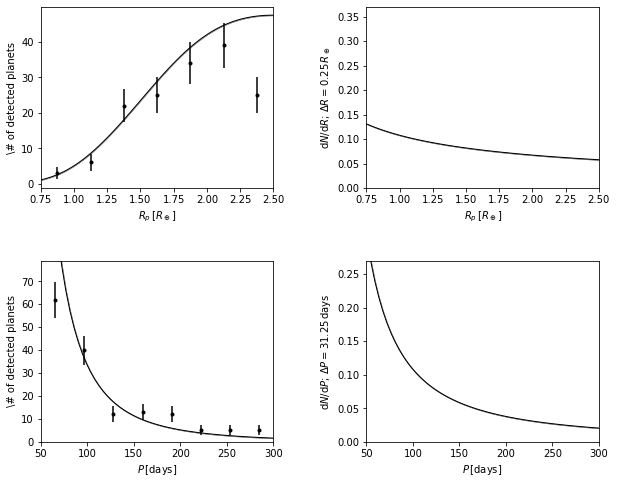

In [7]:
dfm.plot_results(res.x, kois, koi_periods, koi_rps, period_grid, rp_grid, comp=comp)

In [8]:
pos = np.array([np.array(res.x) + np.random.normal(0, 1e-4, (3,)) for _ in range(16)])
sampler = emcee.EnsembleSampler(16, 3, log_prob) 
pos, _, _ = sampler.run_mcmc(pos, 1000)
print("burn-in done")
sampler.reset()
pos, _, _ = sampler.run_mcmc(pos, 4000)

burn-in done


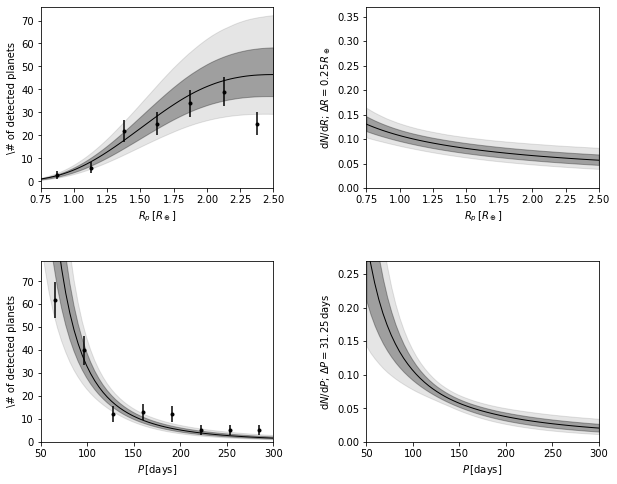

In [9]:
gamma_earth = dfm.plot_results(sampler.flatchain, kois, koi_periods, koi_rps,
                               period_grid, rp_grid, comp=comp)

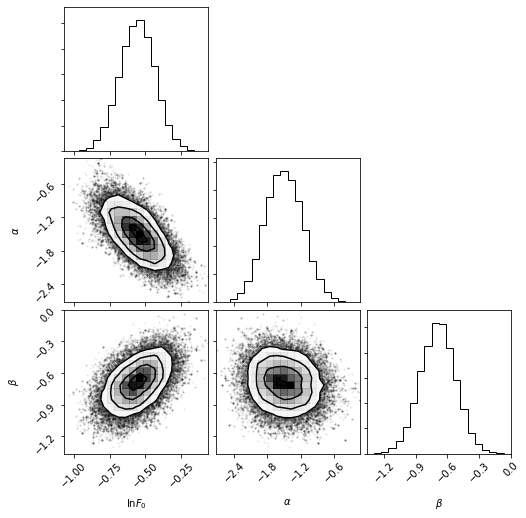

In [10]:
#!pip install corner
_ = corner.corner(sampler.flatchain, labels=[r'$\ln F_0$', r'$\alpha$', r'$\beta$'])